In [1]:
# --- Set cores and seed ---
import os
N_CORES = 4
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={N_CORES}"

import numpy as np
import jax.numpy as jnp
import jax
from jax import random
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['savefig.facecolor'] = 'white'

import networkx as nx

import numpyro
from numpyro.infer import Predictive, MCMC, NUTS
import numpyro.distributions as dist

import src.utils as utils
import src.Models as models

import Data.cs_aarhus.util_data as ud
import Data.cs_aarhus.data_models as dm
import Data.cs_aarhus.data_mcmc as dmcmc

import Simulations.data_gen as dg







In [2]:
network_data = ud.network_data()

print(network_data.keys())
print(network_data["adj_mat_dict"].keys(), network_data["adj_mat_dict"]['facebook'].shape)

dict_keys(['adj_mat_dict', 'triu_dict'])
dict_keys(['lunch', 'facebook', 'leisure', 'work']) (61, 61)


In [3]:
layers = list(network_data["adj_mat_dict"].keys())

for layer in layers:
    print("-" * 40)
    print(f"Layer : {layer}")
    print("n_edge:", network_data["adj_mat_dict"][layer].sum()/2)
    deg = network_data["adj_mat_dict"][layer].sum(axis=1)
    avg_deg = deg[deg > 0].mean()
    print("avg_deg (>0):", avg_deg)
    print("ave_deg:", network_data["adj_mat_dict"][layer].sum(axis=1).mean())
    print("-" * 40)


----------------------------------------
Layer : lunch
n_edge: 193.0
avg_deg (>0): 6.433334
ave_deg: 6.3278685
----------------------------------------
----------------------------------------
Layer : facebook
n_edge: 124.0
avg_deg (>0): 7.75
ave_deg: 4.0655737
----------------------------------------
----------------------------------------
Layer : leisure
n_edge: 88.0
avg_deg (>0): 3.7446806
ave_deg: 2.8852458
----------------------------------------
----------------------------------------
Layer : work
n_edge: 194.0
avg_deg (>0): 6.466667
ave_deg: 6.3606553
----------------------------------------


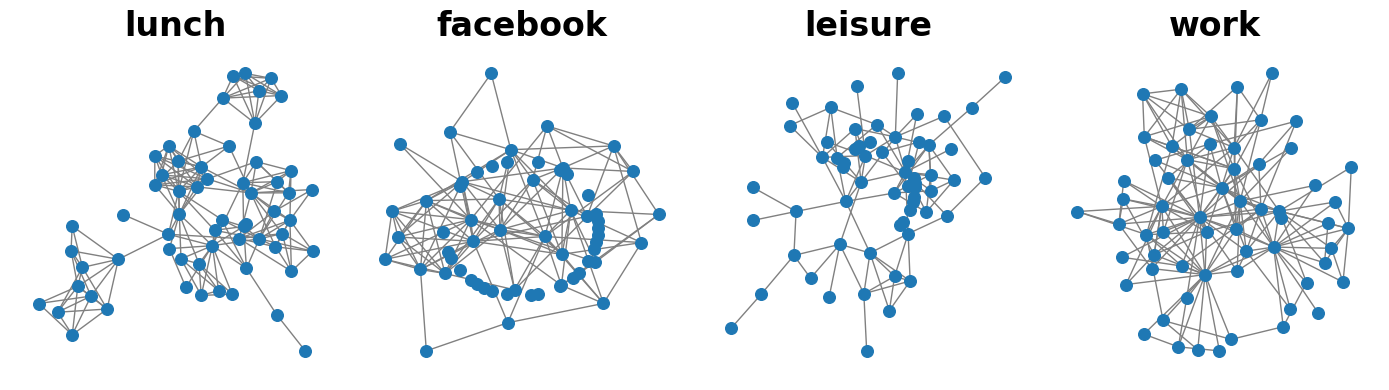

In [4]:

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 4))
for i in range(4):
# for layer in networks_dict.keys():
    degs = network_data["adj_mat_dict"][layers[i]].sum(axis=1) + 1
    G = nx.from_numpy_array(np.array(network_data["adj_mat_dict"][layers[i]]))
    # pos = nx.circular_layout(G)
    pos = nx.kamada_kawai_layout(G)
    # pos = nx.random_layout(G, seed=42)
    nx.draw_networkx(
        G,
        pos=pos,
        ax=axes[i],
        node_size=70,
        # node_size=degs*5 + 10,
        with_labels=False,
        edge_color='gray',
    )
    axes[i].set_title(f"{layers[i]}", fontsize=24, color='black', fontweight='bold')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [5]:
obs_triu, latent_triu = ud.triu_array_obs_n_latent(network_data["triu_dict"],"lunch")

print(obs_triu.shape, latent_triu.shape)


agg_or_triu = ud.aggregate_edges(obs_triu, "or")
agg_and_triu = ud.aggregate_edges(obs_triu, "and")

print(agg_or_triu.shape, agg_and_triu.shape)


network_data = {"triu_vals" : obs_triu,
                "triu_star" : latent_triu,
                "agg_or_triu" : agg_or_triu,
                "agg_and_triu" : agg_and_triu,}

(3, 1830) (1830,)
(1830,) (1830,)


In [6]:
# outcome and treatments data

rng_key, _ = random.split(random.PRNGKey(42))

ETA = jnp.array([-1, 3, 3], dtype=jnp.float32)
RHO = 0.5
SIG_INV = 0.5

data_z_y = ud.generate_data(key=rng_key,
                            triu_star=latent_triu,
                            eta=ETA,
                            rho=RHO,
                            sig_inv=SIG_INV)

print(data_z_y.keys(), data_z_y["Z"].shape, data_z_y["Y"].shape)

dict_keys(['Z', 'true_exposures', 'Y']) (61,) (61,)


In [7]:
data = data_z_y | network_data

for k, v in data.items():
    print(k, v.shape)

Z (61,)
true_exposures (61,)
Y (61,)
triu_vals (3, 1830)
triu_star (1830,)
agg_or_triu (1830,)
agg_and_triu (1830,)


In [8]:
rng_key, _ = random.split(rng_key)
new_z = dg.generate_treatments(rng=rng_key, n=61, pz=0.7)
new_z2 = dg.generate_treatments(rng=rng_key, n=61, pz=0.3)

new_z_arr = jnp.array([new_z, new_z2])

new_expos = ud.compute_exposures(network_data["triu_star"], new_z)
new_expos2 = ud.compute_exposures(network_data["triu_star"], new_z2)
new_mean = ud.get_df_nodes(new_z, new_expos) @ ETA
new_mean2 = ud.get_df_nodes(new_z2, new_expos2) @ ETA
new_estimand = new_mean - new_mean2
print(new_estimand.mean(), new_estimand.std(), new_estimand.min(), new_estimand.max())


true_vals = {
    "eta" : ETA,
    "rho" : RHO,
    "sig_inv" : SIG_INV,
    "triu_star": latent_triu,
}

2.2368853 1.517437 0.25 4.9000006


In [9]:
# mcmc true network
rng_key, _ = random.split(rng_key)
mcmc_true = dmcmc.mcmc_fixed_net(rng_key = rng_key,
                                 data = data,
                                 net_type = "true",
                                 progress_bar=True)

mcmc_true.new_intervention_error_stats(
    new_z = new_z_arr,
    true_estimands = new_estimand,
    true_vals = true_vals,
)

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]     -1.11      0.19     -1.11     -1.43     -0.79   4495.46      1.00
    eta[1]      2.93      0.13      2.93      2.72      3.13   6697.56      1.00
    eta[2]      3.57      0.27      3.57      3.13      4.00   4951.28      1.00
       rho      0.50      0.19      0.50      0.19      0.81   6470.66      1.00
   sig_inv      0.62      0.12      0.61      0.43      0.81   7313.05      1.00

Number of divergences: 0


{'mean': Array(2.3882399, dtype=float32),
 'median': Array(2.27296, dtype=float32),
 'true': Array(2.2368898, dtype=float32),
 'bias': Array(0.15134999, dtype=float32),
 'std': Array(0.18264, dtype=float32),
 'RMSE': Array(0.23719999, dtype=float32),
 'RMSE_rel': Array(0.10604, dtype=float32),
 'MAE': Array(0.16733, dtype=float32),
 'MAPE': Array(0.11982, dtype=float32),
 'q025': Array(2.0313137, dtype=float32),
 'q975': Array(2.7600257, dtype=float32),
 'covering': Array(True, dtype=bool),
 'mean_ind_cover': Array(1., dtype=float32),
 'w_dist': Array(0.9269937, dtype=float32)}

In [10]:
# mcmc agg_or network

rng_key, _ = random.split(rng_key)
mcmc_agg_or = dmcmc.mcmc_fixed_net(rng_key = rng_key,
                                   data = data,
                                   net_type = "agg_or",
                                   progress_bar=True)

mcmc_agg_or.new_intervention_error_stats(
    new_z = new_z_arr,
    true_estimands = new_estimand,
    true_vals = true_vals,
)

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]      0.56      0.35      0.55     -0.02      1.13   4976.57      1.00
    eta[1]      2.43      0.25      2.43      2.03      2.84   6549.59      1.00
    eta[2]      0.21      0.14      0.21     -0.03      0.44   4972.49      1.00
       rho      0.56      0.20      0.57      0.23      0.88   6682.99      1.00
   sig_inv      0.11      0.02      0.11      0.07      0.14   7509.06      1.00

Number of divergences: 0


{'mean': Array(1.2127299, dtype=float32),
 'median': Array(1.12645, dtype=float32),
 'true': Array(2.2368898, dtype=float32),
 'bias': Array(-1.02416, dtype=float32),
 'std': Array(0.38665, dtype=float32),
 'RMSE': Array(1.09471, dtype=float32),
 'RMSE_rel': Array(0.48939, dtype=float32),
 'MAE': Array(1.0270799, dtype=float32),
 'MAPE': Array(0.58592, dtype=float32),
 'q025': Array(0.4471831, dtype=float32),
 'q975': Array(1.9739921, dtype=float32),
 'covering': Array(False, dtype=bool),
 'mean_ind_cover': Array(0.96721, dtype=float32),
 'w_dist': Array(3.9501202, dtype=float32)}

In [11]:
# mcmc agg_and network

rng_key, _ = random.split(rng_key)
mcmc_agg_and = dmcmc.mcmc_fixed_net(rng_key = rng_key,
                                    data = data,
                                    net_type = "agg_and",
                                    progress_bar=True)

mcmc_agg_and.new_intervention_error_stats(
    new_z = new_z_arr,
    true_estimands = new_estimand,
    true_vals = true_vals,
)

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]      0.86      0.21      0.86      0.54      1.21   5246.92      1.00
    eta[1]      2.47      0.27      2.47      2.04      2.90   5512.42      1.00
    eta[2]      1.30      2.60      1.28     -3.03      5.51   6915.37      1.00
       rho      0.40      0.16      0.40      0.12      0.65   4351.07      1.00
   sig_inv      1.00      0.29      0.95      0.54      1.42   4091.55      1.00

Number of divergences: 0


{'mean': Array(1.06653, dtype=float32),
 'median': Array(1.01705, dtype=float32),
 'true': Array(2.2368898, dtype=float32),
 'bias': Array(-1.17035, dtype=float32),
 'std': Array(0.25748998, dtype=float32),
 'RMSE': Array(1.1983399, dtype=float32),
 'RMSE_rel': Array(0.53572, dtype=float32),
 'MAE': Array(1.17035, dtype=float32),
 'MAPE': Array(0.70597, dtype=float32),
 'q025': Array(0.5554775, dtype=float32),
 'q975': Array(1.5728054, dtype=float32),
 'covering': Array(False, dtype=bool),
 'mean_ind_cover': Array(0.96721, dtype=float32),
 'w_dist': Array(4.1191216, dtype=float32)}

In [12]:
# MWG init

rng_key, _ = random.split(rng_key)
mwg_init = dmcmc.MWG_init(rng_key = rng_key,
                            data = data,
                            progress_bar=True).get_init_values()

print(mwg_init.keys())

Initializing parameters for MWG sampler...


  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
      U[0,0,0]     -0.00      1.07      0.01     -1.79      1.69   4504.34      1.00
      U[0,0,1]      0.01      1.08      0.02     -1.69      1.83   4287.04      1.00
      U[0,1,0]      0.04      1.24      0.06     -2.04      1.96   1452.53      1.00
      U[0,1,1]     -0.03      1.21     -0.05     -2.00      1.91   1249.77      1.00
      U[0,2,0]     -0.05      1.27     -0.04     -2.18      1.91   1415.30      1.00
      U[0,2,1]      0.05      1.26      0.06     -2.07      2.00   1964.73      1.00
      U[0,3,0]      0.12      0.97      0.11     -1.42      1.75     40.73      1.07
      U[0,3,1]      0.03      0.96      0.04     -1.59      1.54    173.48      1.01
      U[0,4,0]     -0.02      0.63     -0.02     -1.06      0.99   1063.38      1.00
      U[0,4,1]      0.01      0.61      0.01     -1.00      1.02    943.17      1.01
      U[0,5,0]     -0.05      1.24     -0.08     -2.08      1.95

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]     -0.58      1.22     -0.59     -2.69      1.32   3758.41      1.00
    eta[1]      2.43      0.28      2.43      1.97      2.90   6672.89      1.00
    eta[2]      2.24      1.84      2.25     -0.79      5.22   3881.62      1.00
       rho      0.40      0.20      0.38      0.06      0.70   6322.12      1.00
   sig_inv      0.12      0.02      0.12      0.09      0.16   6652.59      1.00

Number of divergences: 0
MWG init params: 
 eta: [-0.584984   2.4281979  2.2425983] 
 rho: 0.401129 
 sig_inv: 0.12450442
dict_keys(['U', 'eta', 'mu0', 'mu1', 'rho', 'sig_inv', 'sigma0', 'sigma1', 'theta0_0_nrm', 'theta0_1_nrm', 'theta0_2_nrm', 'theta0_3_nrm', 'theta1_0_nrm', 'theta1_1_nrm', 'theta1_2_nrm', 'theta1_3_nrm', 'triu_star', 'u_loc'])


In [27]:
if jnp.abs(mwg_init["eta"][0][2] - 3.0) > 0.2:
    print("Tre")
else:
    print("False")

Tre


In [35]:
probs_obs = data["triu_star"] * 0.99 + (1.0 - data["triu_star"]) * 0.01

noisy_triu_star = jnp.astype(random.bernoulli(key=rng_key, p=probs_obs), jnp.float32)

print(noisy_triu_star.shape)


(1830,)


In [36]:
jnp.mean(data["triu_star"] == mwg_init["triu_star"]), jnp.mean(data["triu_star"] == noisy_triu_star)

(Array(0.8147541, dtype=float32), Array(0.9846995, dtype=float32))

In [17]:
# mwg_init["eta"] = mwg_init["eta"].at[:,2].set(jnp.array([3.1,2.9,3.2,2.8]))
eta_nois = 3.0 + 0.3 * random.normal(rng_key, (4,))
mwg_init["eta"] = mwg_init["eta"].at[:,2].set(eta_nois)
mwg_init["eta"]

Array([[-0.584984 ,  2.4281979,  2.7388825],
       [-0.584984 ,  2.4281979,  3.1300151],
       [-0.584984 ,  2.4281979,  2.8767347],
       [-0.584984 ,  2.4281979,  3.2040966]], dtype=float32)

In [20]:
random.normal(rng_key, )

Array(-0.20245041, dtype=float32)

In [14]:
# MWG sampling
rng_key, _ = random.split(rng_key)
mwg_sampler = dmcmc.MWG_sampler(rng_key = rng_key,
                                data = data,
                                init_params = mwg_init,
                                n_warmup=2000,
                                n_samples=2500,
                                num_chains=4,
                                progress_bar=True)

mwg_sampler.new_intervention_error_stats(
    new_z = new_z_arr,
    true_estimands = new_estimand,
    true_vals = true_vals,
)

# TODO: keep tinkering with the model, init, and mwg sampler

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

mean post eta: [-0.35449424  2.5257738   3.442291  ]


{'mean': Array(1.85973, dtype=float32),
 'median': Array(1.7620399, dtype=float32),
 'true': Array(2.2368898, dtype=float32),
 'bias': Array(-0.37715998, dtype=float32),
 'std': Array(0.34769, dtype=float32),
 'RMSE': Array(0.51297, dtype=float32),
 'RMSE_rel': Array(0.22931999, dtype=float32),
 'MAE': Array(0.61079997, dtype=float32),
 'MAPE': Array(0.44711, dtype=float32),
 'q025': Array(1.1744577, dtype=float32),
 'q975': Array(2.535949, dtype=float32),
 'covering': Array(True, dtype=bool),
 'mean_ind_cover': Array(1., dtype=float32),
 'w_dist': Array(2.1690989, dtype=float32)}

In [14]:
import seaborn as sns

def plot_heatmaps(posterior_probs, true_values):
    """
    Plot two heatmaps side by side:
    - Left: Posterior mean probabilities of edges in the latent adjacency.
    - Right: True adjacency matrix of the latent layer.
    
    Arguments:
    - posterior_probs: n x n matrix of posterior mean probabilities (values in [0,1]).
    - true_values: n x n binary adjacency matrix (values in {0,1}).
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Heatmap of posterior mean probabilities
    sns.heatmap(posterior_probs, ax=axes[0], cmap="coolwarm", vmin=0, vmax=1, annot=False)
    axes[0].set_title("Posterior Mean Probabilities")
    
    # Heatmap of true adjacency matrix
    sns.heatmap(true_values, ax=axes[1], cmap="coolwarm", vmin=0, vmax=1, annot=False)
    axes[1].set_title("True Adjacency Matrix")
    
    plt.tight_layout()
    plt.show()

In [18]:
network_data.keys()

dict_keys(['triu_vals', 'triu_star', 'agg_or_triu', 'agg_and_triu'])

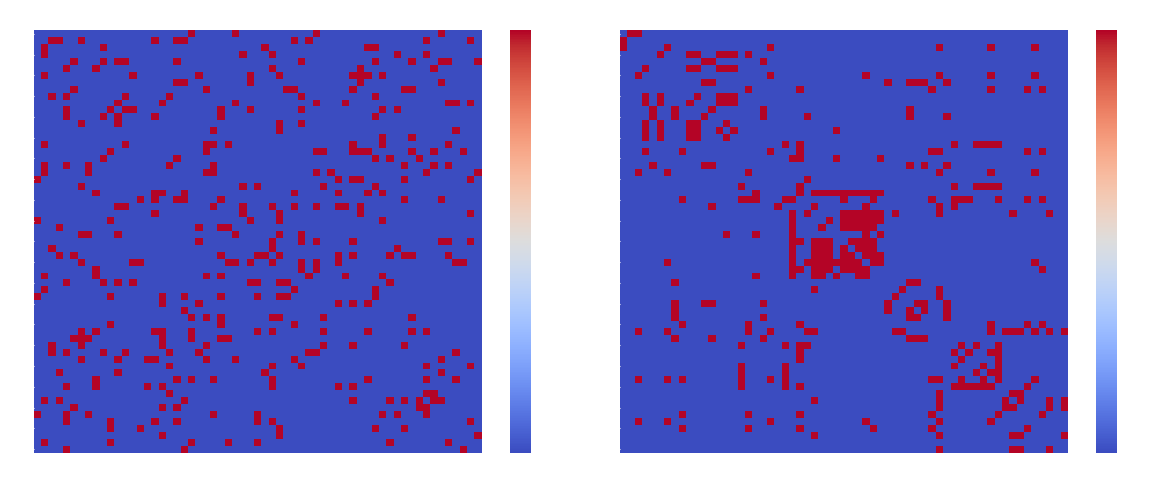

In [19]:
post_probs_mat = ud.triu_to_mat(mwg_init["triu_star"][0,:])
true_mat = ud.triu_to_mat(network_data["triu_star"])
plot_heatmaps(post_probs_mat, true_mat)

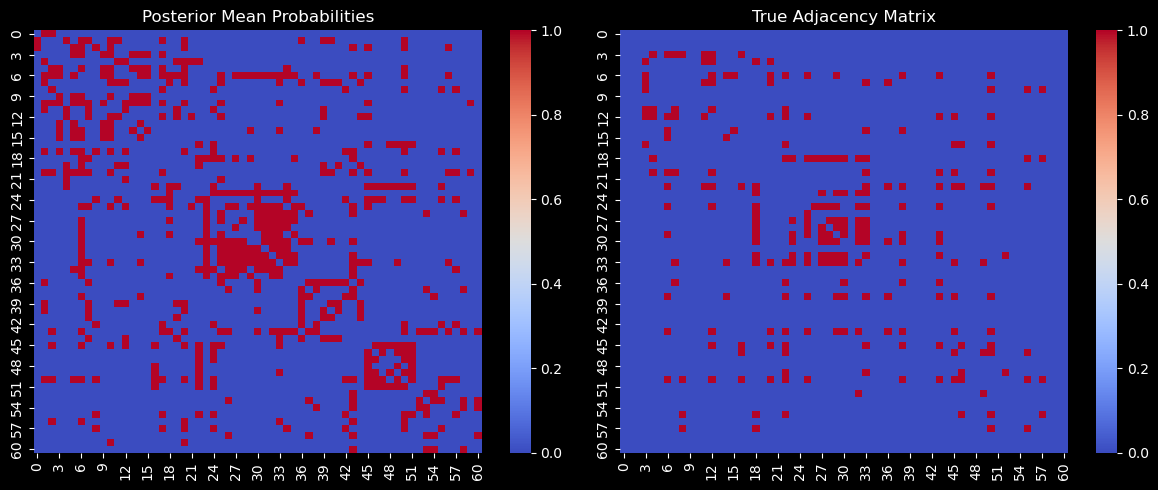

In [18]:
# aggreagted network by either 'OR' or 'AND' for all edges in observed layers

def aggregate_edges(triu_vals, method="or"):
    """
    Aggregate edges from multiple layers into a single adjacency matrix.
    
    Arguments:
    - triu_vals: n_layers x n choose 2 array of edge values.
    - method: "or" or "and" for how to aggregate edges.
    
    Returns:
    - n x n adjacency matrix of aggregated edges.
    """
    if method == "or":
        return jnp.any(triu_vals, axis=0)
    elif method == "and":
        return jnp.all(triu_vals, axis=0)
    else:
        raise ValueError("Invalid aggregation method. Must be 'or' or 'and'.")
    
agg_or = aggregate_edges(obs_layers_triu, method="or")
agg_and = aggregate_edges(obs_layers_triu, method="and")

plot_heatmaps(triu_to_mat(agg_or), true_mat)

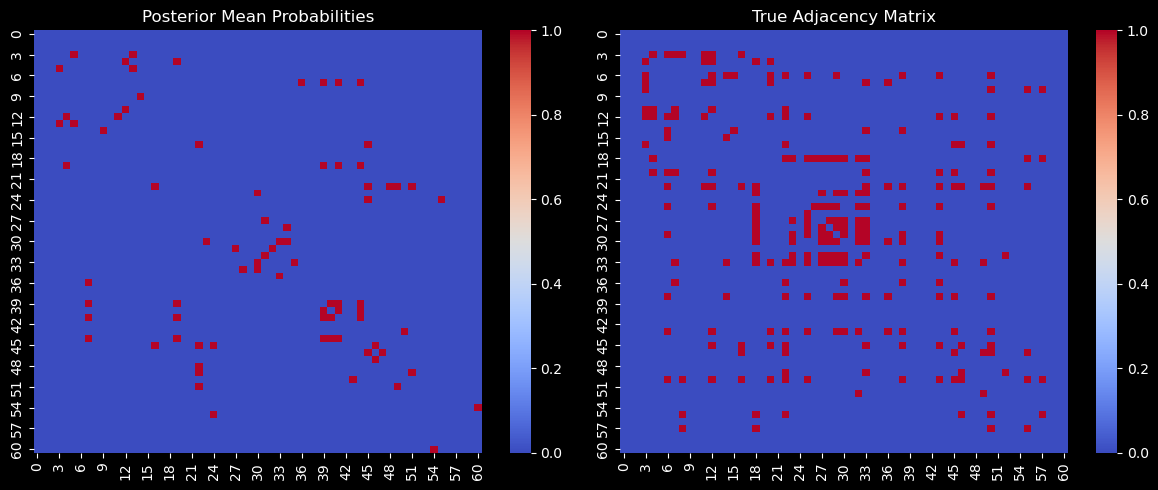

In [19]:
plot_heatmaps(triu_to_mat(agg_and), true_mat)

In [20]:
@jax.jit
def cut_post_log_density(triu_vals, post_probs):
    """
    Compute the log density of the posterior probabilities for the observed edges.
    
    Arguments:
    - triu_vals: n_layers x n choose 2 array of edge values.
    - post_probs: n choose 2 array of posterior probabilities.
    
    Returns:
    - log likelihood of the observed edges under the posterior probabilities.
    """
    return jnp.sum(triu_vals * jnp.log(post_probs) + (1 - triu_vals) * jnp.log1p(post_probs))

vmap_post_density = jax.vmap(cut_post_log_density, in_axes=(0, None))

def max_post_net(triu_samps, probs):
    """
    Find the network with the highest posterior density.
    
    Arguments:
    - triu_samps: n_samples x n choose 2 array of posterior samples.
    - probs: n choose 2 array of posterior probabilities.
    
    Returns:
    - n choose 2 array of the network with the highest posterior density.
    """
    log_densities = vmap_post_density(triu_samps, probs)
    max_idx = jnp.argmax(log_densities)
    return triu_samps[max_idx]




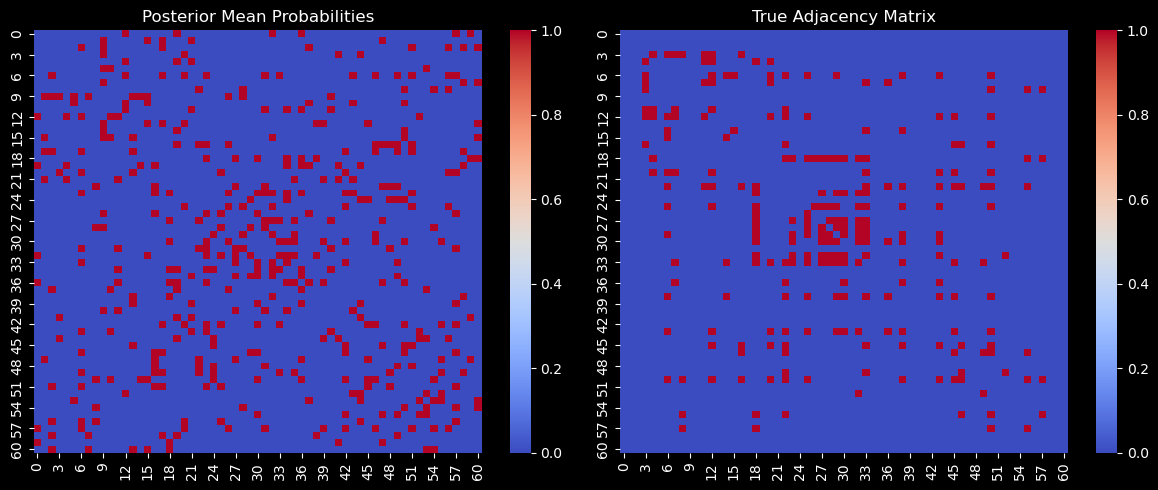

In [21]:
max_post_triu = max_post_net(post_triu, post_probs)

plot_heatmaps(triu_to_mat(max_post_triu), true_mat)

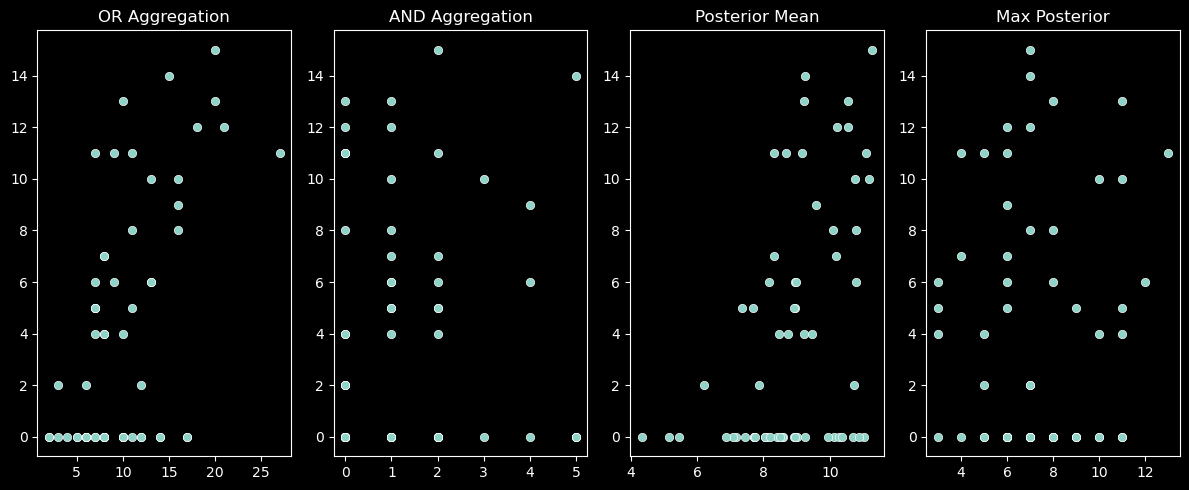

or~true cor 0.5666671
and~true cor 0.04013872
post~true cor 0.43994018
max_post~true cor 0.07717976
or~true rmse 7.5270004
and~true rmse 5.5927353
post~true rmse 6.4362974
max_post~true rmse 5.989061


In [22]:
agg_or_degs = compute_deg(agg_or)
agg_and_degs = compute_deg(agg_and)
max_post_deg = compute_deg(max_post_triu)

fig, axs = plt.subplots(1, 4, figsize=(12, 5))

sns.scatterplot(x=agg_or_degs, y=true_deg, ax=axs[0])
axs[0].set_title("OR Aggregation")

sns.scatterplot(x=agg_and_degs, y=true_deg, ax=axs[1])
axs[1].set_title("AND Aggregation")

sns.scatterplot(x=post_degs.mean(axis=0), y=true_deg, ax=axs[2])
axs[2].set_title("Posterior Mean")

sns.scatterplot(x=max_post_deg, y=true_deg, ax=axs[3])
axs[3].set_title("Max Posterior")

plt.tight_layout()
plt.show()

print("or~true cor", jnp.corrcoef(agg_or_degs, true_deg)[0,1])
print("and~true cor", jnp.corrcoef(agg_and_degs, true_deg)[0,1])
print("post~true cor", jnp.corrcoef(post_degs.mean(axis=0), true_deg)[0,1])
print("max_post~true cor", jnp.corrcoef(max_post_deg, true_deg)[0,1])

print("or~true rmse", jnp.sqrt(jnp.mean((agg_or_degs - true_deg)**2)))
print("and~true rmse", jnp.sqrt(jnp.mean((agg_and_degs - true_deg)**2)))
print("post~true rmse", jnp.sqrt(jnp.mean((post_degs.mean(axis=0) - true_deg)**2)))
print("max_post~true rmse", jnp.sqrt(jnp.mean((max_post_deg - true_deg)**2)))

In [23]:
# generate synthetic data
import Simulations.data_gen as dg
import src.utils as utils

@jax.jit
def degree_centrality(adj_matrix):
    """
    Compute normalized degree centrality

    Parameters:
    adj_matrix (jnp.ndarray): Square adjacency matrix (n x n)

    Returns:
    jnp.ndarray: Vector of normalized degree centralities
    """
    # Compute degrees (sum of rows for undirected graph)
    degrees = jnp.sum(adj_matrix, axis=1)

    # Normalize by maximum possible degree (n-1)
    n = adj_matrix.shape[0]
    # return degrees / (n - 1)
    return degrees / (n - 1)

@jax.jit
def compute_exposures(triu_star, Z):
    mat_star = triu_to_mat(triu_star)
    deg_cen = degree_centrality(mat_star)
    return utils.weighted_exposures(Z, deg_cen, mat_star)

vmap_compute_exposures = jax.vmap(compute_exposures, in_axes=(0, None))

def CAR_cov(triu_vals, sig_inv, rho, n):
    # Cov(Y) = \Sigma = sig_inv * (D - rho*A)^-1
    # So precision = \Sigma^{-1} = (1/sig_inv) * (D - rho*A)
    adj_mat = triu_to_mat(triu_vals)
    adj_mat += jnp.eye(n)  # Add self-loops
    degs_diag = jnp.sum(adj_mat, axis=1) * jnp.eye(n) 
    # Compute precision matrix Sigma^{-1}
    precis_ = sig_inv * (degs_diag - rho * adj_mat) 
    # Return Sigma
    return jnp.linalg.inv(precis_)


def generate_data(key, n, triu_star, eta, rho, sig_inv):
    z_key, y_key = random.split(key)
    Z = dg.generate_treatments(rng=z_key, n=n)
    expos = compute_exposures(triu_star, Z)
    df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, expos]))
    mean_y = df_nodes @ eta
    y_cov = CAR_cov(triu_star, sig_inv, rho, n)
    # y_cov = random.normal(y_key, shape=(n,))*sig_inv 
    print("y_cov is positive definite?", jnp.all(jnp.linalg.eigvals(y_cov) > 0))

    y = random.multivariate_normal(y_key, mean_y, y_cov)
    # y = mean_y + y_cov

    return {
        "Z": Z,
        "true_exposures": expos,
        "Y": y,
    }

In [24]:

ETA = jnp.array([-1, 3, 3])
SIG_INV = 1.0
RHO = 0.5

rng_key, _ = random.split(rng_key)
true_data = generate_data(key=rng_key,
                        n=num_nodes,
                        triu_star=latent_layer_triu,
                        eta=ETA,
                        rho=RHO,
                        sig_inv=SIG_INV)

print(true_data["Y"].shape)

y_cov is positive definite? True
(61,)


(array([34.,  4.,  5.,  4.,  3.,  2.,  4.,  2.,  1.,  2.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

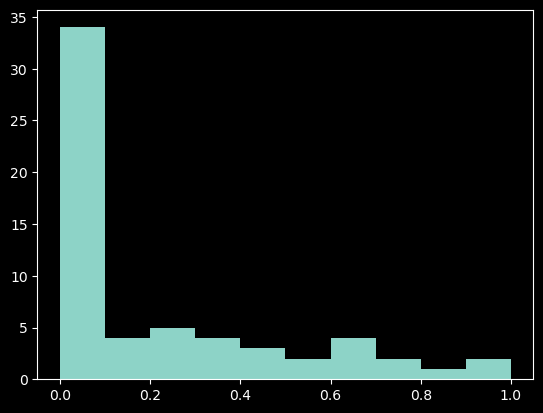

In [25]:
plt.hist(true_data["true_exposures"], bins=10)

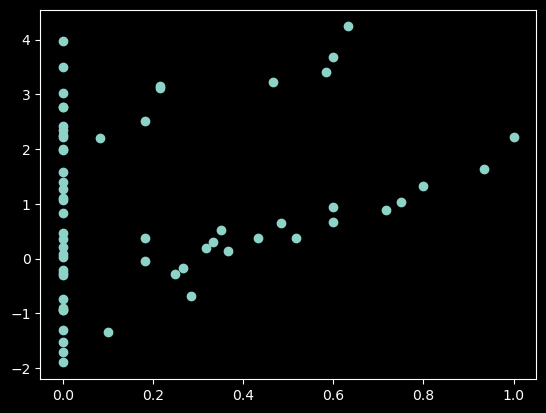

In [26]:
plt.scatter(true_data["true_exposures"], true_data["Y"])

In [27]:
def outcome_model(Z, exposures, Y):
    n = Z.shape[0]
    with numpyro.plate("eta_plate", 3):
        eta = numpyro.sample("eta", dist.Normal(0.0, 3.0))

    sig_inv = numpyro.sample("sig_inv", dist.Gamma(2,2))
    mean_y = jnp.transpose(jnp.stack([jnp.ones(n), Z, exposures])) @ eta

    numpyro.sample("Y", dist.Normal(mean_y, sig_inv), obs=Y)

In [28]:
import src.Models as models

# run plugin model with true data

obs_df_node = jnp.transpose(jnp.stack([jnp.ones(num_nodes), true_data["Z"], true_data["true_exposures"]]))
true_adj_mat = triu_to_mat(latent_layer_triu) + jnp.eye(num_nodes)

rng_key, _ = random.split(rng_key)
# plugin_kernel = NUTS(outcome_model)
plugin_kernel = NUTS(models.plugin_outcome_model)
plugin_mcmc = MCMC(plugin_kernel, num_warmup=2000, num_samples=2500, num_chains=4)

plugin_mcmc.run(rng_key, 
                # Z=true_data["Z"],
                # exposures=true_data["true_exposures"],
                df_nodes=obs_df_node,
                adj_mat=true_adj_mat,
                Y=true_data["Y"])

plugin_mcmc.print_summary()

plugin_samples = plugin_mcmc.get_samples()
print(plugin_samples.keys())


  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]     -0.80      0.13     -0.80     -1.01     -0.60   4535.68      1.00
    eta[1]      2.89      0.12      2.89      2.69      3.09   5466.81      1.00
    eta[2]      2.74      0.20      2.74      2.42      3.08   4828.19      1.00
       rho      0.44      0.15      0.45      0.20      0.70   5243.85      1.00
   sig_inv      1.36      0.32      1.33      0.87      1.88   5698.54      1.00

Number of divergences: 0
dict_keys(['eta', 'rho', 'sig_inv'])


In [29]:
rng_key, _ = random.split(rng_key)
new_z = dg.generate_treatments(rng=rng_key, n=num_nodes, pz=0.7)
new_z2 = dg.generate_treatments(rng=rng_key, n=num_nodes, pz=0.3)
new_expos = compute_exposures(latent_layer_triu, new_z)
new_expos2 = compute_exposures(latent_layer_triu, new_z2)
new_mean = jnp.transpose(jnp.stack([jnp.ones(num_nodes), new_z, new_expos])) @ ETA
new_mean2 = jnp.transpose(jnp.stack([jnp.ones(num_nodes), new_z2, new_expos2])) @ ETA
new_estimand = new_mean - new_mean2
print(new_estimand.mean(), new_estimand.std(), new_estimand.min(), new_estimand.max())

1.6303277 1.4486365 0.0 3.9500003


In [30]:
from numpyro.infer import Predictive

new_df = jnp.transpose(jnp.stack([jnp.ones(num_nodes), new_z, new_expos]))
new_df2 = jnp.transpose(jnp.stack([jnp.ones(num_nodes), new_z2, new_expos2]))

# plugin_predictive = Predictive(outcome_model, plugin_samples, return_sites=["Y"])
plugin_predictive = Predictive(models.plugin_outcome_model, plugin_samples, return_sites=["Y"])
rng_key, _ = random.split(rng_key)
estimate_1 = plugin_predictive(rng_key, 
                            # Z=new_z,
                            # exposures=new_expos,
                            df_nodes=new_df,
                            adj_mat = true_adj_mat,
                            Y=None)["Y"]

rng_key, _ = random.split(rng_key)
estimate_2 = plugin_predictive(rng_key, 
                            # Z=new_z2,
                            # exposures=new_expos2,
                            df_nodes=new_df2,
                            adj_mat = true_adj_mat,
                            Y=None)["Y"]

plugin_estimates = estimate_1 - estimate_2
print(plugin_estimates.shape, plugin_estimates.mean())



(10000, 61) 1.5475068


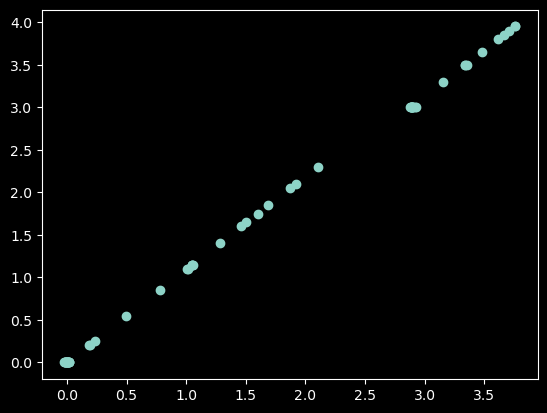

In [31]:
plt.scatter(plugin_estimates.mean(axis=0), new_estimand)

In [32]:
# run with posterior exposures

# get posterior exposures

post_expos = vmap_compute_exposures(post_triu, true_data["Z"]).mean(axis=0)
post_df = jnp.transpose(jnp.stack([jnp.ones(num_nodes), true_data["Z"], post_expos]))

post_adj_mat = triu_to_mat(max_post_triu) + jnp.eye(num_nodes)

# run mcmc
rng_key, _ = random.split(rng_key)
post_mcmc = MCMC(plugin_kernel, num_warmup=2000, num_samples=2500, num_chains=4)
post_mcmc.run(rng_key, 
                # Z=true_data["Z"],
                # exposures=post_expos,
                df_nodes = post_df,
                adj_mat=post_adj_mat,
                Y=true_data["Y"])

post_mcmc.print_summary()

post_samples = post_mcmc.get_samples()


  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]     -1.20      0.65     -1.21     -2.26     -0.14   3818.20      1.00
    eta[1]      2.29      0.27      2.29      1.86      2.74   6613.44      1.00
    eta[2]      1.86      0.90      1.88      0.31      3.28   3878.04      1.00
       rho      0.48      0.21      0.48      0.14      0.82   6437.67      1.00
   sig_inv      0.12      0.02      0.12      0.09      0.16   7139.27      1.00

Number of divergences: 0


In [33]:
# post_estimand with true model

post_expos_new_z = vmap_compute_exposures(post_triu, new_z).mean(axis=0)
post_expos_new_z2 = vmap_compute_exposures(post_triu, new_z2).mean(axis=0)

new_df_post = jnp.transpose(jnp.stack([jnp.ones(num_nodes), new_z, post_expos_new_z]))
new_df_post2 = jnp.transpose(jnp.stack([jnp.ones(num_nodes), new_z2, post_expos_new_z2]))


# post_predictive = Predictive(outcome_model, post_samples, return_sites=["Y"])
post_predictive = Predictive(models.plugin_outcome_model, post_samples, return_sites=["Y"])
rng_key, _ = random.split(rng_key)
post_mean_1 = post_predictive(rng_key, 
                                # Z=new_z,
                                # exposures=post_expos_new_z,
                                df_nodes = new_df_post,
                                adj_mat = post_adj_mat,
                                Y=None)["Y"]

rng_key, _ = random.split(rng_key)
post_mean_2 = post_predictive(rng_key,
                                # Z=new_z2,
                                # exposures=post_expos_new_z2,
                                df_nodes = new_df_post2,
                                adj_mat = post_adj_mat,
                                Y=None)["Y"]

post_estimates = post_mean_1 - post_mean_2
# post_estimates = post_samples_predictive["Y"]

print(post_estimates.shape, post_estimates.mean())

(10000, 61) 1.9232627


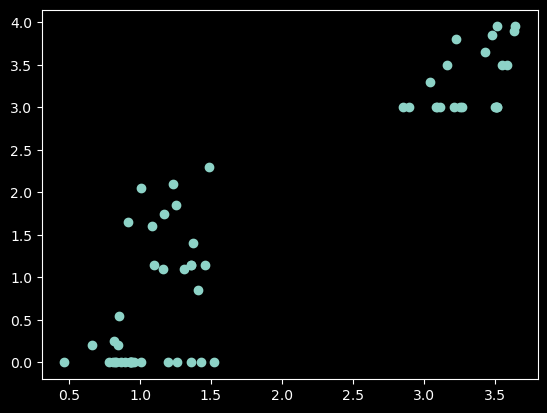

In [34]:
plt.scatter(post_estimates.mean(axis=0), new_estimand)

In [35]:
utils.compute_error_stats(post_estimates=plugin_estimates,
                          true_estimand=new_estimand,
                          wasserstein_dist=1.0)


{'mean': Array(1.5475099, dtype=float32),
 'median': Array(1.51861, dtype=float32),
 'true': Array(1.63033, dtype=float32),
 'bias': Array(-0.08282, dtype=float32),
 'std': Array(0.173, dtype=float32),
 'RMSE': Array(0.19181, dtype=float32),
 'RMSE_rel': Array(0.11764999, dtype=float32),
 'MAE': Array(0.08639, dtype=float32),
 'MAPE': Array(3734.1672, dtype=float32),
 'q025': Array(1.2153591, dtype=float32),
 'q975': Array(1.8916421, dtype=float32),
 'covering': Array(True, dtype=bool),
 'mean_ind_cover': Array(1., dtype=float32),
 'w_dist': 1.0}

In [36]:
utils.compute_error_stats(post_estimates=post_estimates,
                          true_estimand=new_estimand,
                          wasserstein_dist=1.0)


{'mean': Array(1.92326, dtype=float32),
 'median': Array(1.8981199, dtype=float32),
 'true': Array(1.63033, dtype=float32),
 'bias': Array(0.29293, dtype=float32),
 'std': Array(0.60446, dtype=float32),
 'RMSE': Array(0.6717, dtype=float32),
 'RMSE_rel': Array(0.412, dtype=float32),
 'MAE': Array(0.56303996, dtype=float32),
 'MAPE': Array(309387.1, dtype=float32),
 'q025': Array(0.71255183, dtype=float32),
 'q975': Array(3.1065369, dtype=float32),
 'covering': Array(True, dtype=bool),
 'mean_ind_cover': Array(1., dtype=float32),
 'w_dist': 1.0}

In [37]:
# now with agg_or network

agg_or_expos = compute_exposures(agg_or, true_data["Z"])

agg_df_nodes = jnp.transpose(jnp.stack([jnp.ones(num_nodes), true_data["Z"], agg_or_expos]))
agg_adj_mat = triu_to_mat(agg_or) + jnp.eye(num_nodes)

# run mcmc
rng_key, _ = random.split(rng_key)
agg_or_mcmc = MCMC(plugin_kernel, num_warmup=2000, num_samples=2500, num_chains=4)
agg_or_mcmc.run(rng_key, 
                # Z=true_data["Z"],
                # exposures=agg_or_expos,
                df_nodes = agg_df_nodes,
                adj_mat=agg_adj_mat,
                Y=true_data["Y"])

agg_or_mcmc.print_summary()

agg_or_samples = agg_or_mcmc.get_samples()

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]     -0.28      0.38     -0.28     -0.91      0.34   5391.24      1.00
    eta[1]      2.20      0.27      2.19      1.76      2.65   7247.38      1.00
    eta[2]      0.47      0.27      0.47      0.01      0.89   5844.34      1.00
       rho      0.49      0.21      0.49      0.16      0.85   6735.86      1.00
   sig_inv      0.09      0.02      0.09      0.06      0.12   7421.62      1.00

Number of divergences: 0


In [38]:
# predictive estimate

agg_or_post_expos = compute_exposures(agg_or, new_z)
agg_or_post_expos2 = compute_exposures(agg_or, new_z2)

agg_or_post_df = jnp.transpose(jnp.stack([jnp.ones(num_nodes), new_z, agg_or_post_expos]))
agg_or_post_df2 = jnp.transpose(jnp.stack([jnp.ones(num_nodes), new_z2, agg_or_post_expos2]))

# agg_or_predictive = Predictive(outcome_model, agg_or_samples, return_sites=["Y"])
agg_or_predictive = Predictive(models.plugin_outcome_model, agg_or_samples, return_sites=["Y"])
rng_key, _ = random.split(rng_key)
agg_or_mean1 = agg_or_predictive(rng_key, 
                                # Z=new_z,
                                # exposures=agg_or_post_expos,
                                df_nodes = agg_or_post_df,
                                adj_mat = agg_adj_mat,
                                Y=None)["Y"]

rng_key, _ = random.split(rng_key)
agg_or_mean2 = agg_or_predictive(rng_key,
                                # Z=new_z2,
                                # exposures=agg_or_post_expos2,
                                df_nodes = agg_or_post_df2,
                                adj_mat = agg_adj_mat,
                                Y=None)["Y"]

# agg_or_estimates = agg_or_samples_predictive["Y"]
agg_or_estimates = agg_or_mean1 - agg_or_mean2
print(agg_or_estimates.shape, agg_or_estimates.mean())

utils.compute_error_stats(post_estimates=agg_or_estimates,
                            true_estimand=new_estimand,
                            wasserstein_dist=1.0)

(10000, 61) 1.1667118


{'mean': Array(1.16671, dtype=float32),
 'median': Array(1.1412799, dtype=float32),
 'true': Array(1.63033, dtype=float32),
 'bias': Array(-0.46361998, dtype=float32),
 'std': Array(0.39927, dtype=float32),
 'RMSE': Array(0.61184996, dtype=float32),
 'RMSE_rel': Array(0.37528998, dtype=float32),
 'MAE': Array(0.6333, dtype=float32),
 'MAPE': Array(84465.37, dtype=float32),
 'q025': Array(0.3525667, dtype=float32),
 'q975': Array(1.9173334, dtype=float32),
 'covering': Array(True, dtype=bool),
 'mean_ind_cover': Array(1., dtype=float32),
 'w_dist': 1.0}

In [39]:
# agg_and 

agg_and_expos = compute_exposures(agg_and, true_data["Z"])

agg_and_df = jnp.transpose(jnp.stack([jnp.ones(num_nodes), true_data["Z"], agg_and_expos]))

agg_and_adj_mat = triu_to_mat(agg_and) + jnp.eye(num_nodes)

# run mcmc
rng_key, _ = random.split(rng_key)
agg_and_mcmc = MCMC(plugin_kernel, num_warmup=2000, num_samples=2500, num_chains=4)
agg_and_mcmc.run(rng_key, 
                # Z=true_data["Z"],
                # exposures=agg_and_expos,
                df_nodes = agg_and_df,
                adj_mat=agg_and_adj_mat,
                Y=true_data["Y"])

agg_and_mcmc.print_summary()

agg_and_samples = agg_and_mcmc.get_samples()


  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]      0.30      0.21      0.30     -0.04      0.65   7032.41      1.00
    eta[1]      1.82      0.28      1.81      1.35      2.28   7452.12      1.00
    eta[2]      0.06      1.76      0.03     -2.75      3.01   8938.89      1.00
       rho      0.21      0.12      0.20      0.02      0.38   8763.17      1.00
   sig_inv      0.43      0.08      0.42      0.30      0.56   8198.03      1.00

Number of divergences: 0


In [40]:
# predictive estimate

agg_and_post_expos = compute_exposures(agg_and, new_z)
agg_and_post_expos2 = compute_exposures(agg_and, new_z2)

agg_and_post_df = jnp.transpose(jnp.stack([jnp.ones(num_nodes), new_z, agg_and_post_expos]))
agg_and_post_df2 = jnp.transpose(jnp.stack([jnp.ones(num_nodes), new_z2, agg_and_post_expos2]))

# agg_and_predictive = Predictive(outcome_model, agg_and_samples, return_sites=["Y"])
agg_and_predictive = Predictive(models.plugin_outcome_model, agg_and_samples, return_sites=["Y"])

rng_key, _ = random.split(rng_key)
agg_and_mean1 = agg_and_predictive(rng_key, 
                                    # Z=new_z,
                                    # exposures=agg_and_post_expos,
                                    df_nodes = agg_and_post_df,
                                    adj_mat = agg_and_adj_mat,
                                    Y=None)["Y"]

rng_key, _ = random.split(rng_key)
agg_and_mean2 = agg_and_predictive(rng_key,
                                    # Z=new_z2,
                                    # exposures=agg_and_post_expos2,
                                    df_nodes = agg_and_post_df2,
                                    adj_mat = agg_and_adj_mat,
                                    Y=None)["Y"]

agg_and_estimates = agg_and_mean1 - agg_and_mean2
# agg_and_estimates = agg_and_samples_predictive["Y"]
print(agg_and_estimates.shape, agg_and_estimates.mean())

utils.compute_error_stats(post_estimates=agg_and_estimates,
                            true_estimand=new_estimand,
                            wasserstein_dist=1.0)


(10000, 61) 0.6890204


{'mean': Array(0.68902, dtype=float32),
 'median': Array(0.60529, dtype=float32),
 'true': Array(1.63033, dtype=float32),
 'bias': Array(-0.94131, dtype=float32),
 'std': Array(0.27289, dtype=float32),
 'RMSE': Array(0.98006, dtype=float32),
 'RMSE_rel': Array(0.60115, dtype=float32),
 'MAE': Array(0.94470996, dtype=float32),
 'MAPE': Array(3635.374, dtype=float32),
 'q025': Array(0.15541287, dtype=float32),
 'q975': Array(1.2224201, dtype=float32),
 'covering': Array(False, dtype=bool),
 'mean_ind_cover': Array(0.98361, dtype=float32),
 'w_dist': 1.0}